# 🧪 Mechanisms of Action (MoA) Prediction Tutorial - Code Walkthrough 🧬

## **📌 Introduction**
Welcome to the MoA Prediction tutorial! In this guide, we will explore how to use machine learning techniques to predict drug mechanisms based on gene expression data. The dataset used is from the **Kaggle MoA competition**, which focuses on multi-label classification of drug effects.

**Background: Understanding the Mechanism of Action (MoA) in Drug Discovery**  

The **Mechanism of Action (MoA)** of a drug describes how a molecule interacts with biological targets to produce its pharmacological effects. According to the **National Cancer Institute (NCI)**, MoA refers to "how a drug or other substance produces an effect in the body". For example, a drug’s mechanism of action could be how it affects a specific target in a cell, such as an enzyme, or a cell function, such as cell growth. Knowing the mechanism of action of a drug may help provide information about the safety of the drug and how it affects the body. It may also help identify the right dose of a drug and which patients are most likely to respond to treatment (NCI, *NIH*).  

Historically, drug discovery was largely empirical. Many widely used drugs were discovered through **serendipity and traditional medicine**, long before their exact biological effects were understood. For instance, **paracetamol (acetaminophen)** was in clinical use for decades before researchers determined its MoA, which involves inhibition of cyclooxygenase (COX) enzymes and modulation of the endocannabinoid system. Similarly, early **antibiotics like penicillin** were discovered through natural processes, with their detailed molecular interactions uncovered much later.  

With advances in **molecular biology, high-throughput screening, and computational drug design**, modern pharmacology has transitioned toward a **target-based drug discovery model**. In this framework, researchers first **identify a disease-associated molecular target**, such as a receptor or enzyme, and then **design drugs** that selectively modulate its activity. This **rational drug design** approach increases efficacy, reduces side effects, and enables **personalized medicine** by tailoring treatments to individual patients' biological profiles.

---

**Why is Understanding MoA Important?**  

Understanding the MoA of a drug is **crucial** for several reasons, particularly in improving **efficacy, safety, and precision medicine**.  

1. **Optimizing Drug Delivery & Pharmacokinetics**  
   - As highlighted in *Holland-Frei Cancer Medicine*, a drug’s effect depends not only on its biochemical interaction with a target but also on **how well it reaches the target**. Factors such as **blood flow, diffusion characteristics, plasma protein binding, and metabolism** determine whether a drug can effectively engage its intended site of action (Ratain & Plunkett, 2003).  
   - For example, **chemotherapy drugs** targeting tumors face challenges such as **limited vascularization in large tumors**, which can reduce drug penetration and lead to treatment resistance.

2. **Enhancing Safety & Reducing Toxicity**  
   - Without a clear understanding of MoA, drugs may **interact with unintended targets**, causing harmful side effects. For example, **off-target interactions** are responsible for severe adverse reactions in some cancer therapies, where drugs intended to inhibit tumor growth also damage normal, rapidly dividing cells.

3. **Identifying Drug Resistance Mechanisms**  
   - Many cancers and infectious diseases develop resistance through **alterations in drug targets, enhanced drug efflux, or metabolic adaptations**. Understanding MoA allows researchers to anticipate resistance mechanisms and develop **combination therapies** that can overcome resistance.

4. **Guiding Drug Repurposing & Personalized Medicine**  
   - Drugs with well-characterized MoAs can be **repurposed** for new indications. For instance, the **anticancer drug methotrexate**, originally developed as a folate analog for leukemia, is now used for **autoimmune diseases** such as rheumatoid arthritis.
   - **Biomarker-driven drug selection** also relies on MoA knowledge. Precision oncology drugs, such as **tyrosine kinase inhibitors (TKIs)**, are prescribed based on the presence of specific mutations (e.g., **EGFR inhibitors** for non-small cell lung cancer with EGFR mutations).



### **✨ What We’ll Cover:**
1. ✅ **Setup & Data Preparation**
2. 🔍 **Feature Engineering**
3. 📊 **Preprocessing & Normalization**
4. 🎭 **Dimensionality Reduction**
5. 🤖 **Deep Learning Model Training**
6. 📈 **Evaluation & Predictions**

---
## **1️⃣ Setup & Data Preparation**
## 🔧 **Install & Import Required Libraries**  
To begin, we install and import all necessary libraries for data processing, deep learning, and visualization. This includes `numpy`, `pandas`, `torch`, and `sklearn` for model training and preprocessing.  

## 🏗️ **Set Random Seed for Reproducibility**  
Setting a seed ensures that all experiments produce consistent results, making debugging easier and avoiding randomness in dataset splits, weight initialization, and shuffling.  


## 📂 **Load Dataset**  
We load multiple files:  
- `train_drug.csv`: Contains gene expression and cell viability features.  
- `train_targets_scored.csv`: Contains labeled mechanisms of action (MoA) for supervised training.  
- `train_targets_nonscored.csv`: Additional MoA labels not used for competition scoring.  

In [68]:
!pip install kaggle --upgrade -q

from google.colab import files

In [70]:
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [71]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /content/kaggle.json
!kaggle competitions download -c lish-moa
!unzip lish-moa.zip -d lish_moa_data

lish-moa.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  lish-moa.zip
replace lish_moa_data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace lish_moa_data/test_features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace lish_moa_data/train_drug.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace lish_moa_data/train_features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace lish_moa_data/train_targets_nonscored.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace lish_moa_data/train_targets_scored.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [98]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA, FactorAnalysis
# from umap import UMAP

SEED = 2025666
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything()

In [99]:
train_features = pd.read_csv("/content/lish_moa_data/train_features.csv")
train_targets_scored = pd.read_csv("/content/lish_moa_data/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("/content/lish_moa_data/train_targets_nonscored.csv")

In [100]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# 🔷 **2. Feature Engineering**  
## 🚫 **Filter Out Control Data**  
The dataset includes untreated control samples, which do not contribute to learning drug responses. We remove all samples labeled as "control" (`cp_type != "trt_cp"`) and keep only treatment-related data.  
## ❌ **Handle Missing Values**  
To ensure data quality, we check for missing values and remove rows where applicable. This step prevents errors during model training and improves prediction accuracy.  


In [127]:
train_features = train_features[train_features["cp_type"]=="trt_cp"].reset_index(drop=True)
train_targets_scored = train_targets_scored.loc[train_features.index].reset_index(drop=True)
train_targets_nonscored = train_targets_nonscored.loc[train_features.index].reset_index(drop=True)

In [128]:
missing_counts = train_features.isnull().sum().sum()
print(f"Total missing values in dataset before cleaning: {missing_counts}")

initial_rows = train_features.shape[0]

train_features = train_features.dropna(axis=0).reset_index(drop=True)
train_targets_scored = train_targets_scored.loc[train_features.index].reset_index(drop=True)
train_targets_nonscored = train_targets_nonscored.loc[train_features.index].reset_index(drop=True)

final_rows = train_features.shape[0]
removed_rows = initial_rows - final_rows
print(f"Number of rows removed due to missing values: {removed_rows}")
print(f"Remaining rows after cleaning: {final_rows}")

Total missing values in dataset before cleaning: 0
Number of rows removed due to missing values: 0
Remaining rows after cleaning: 21948


# 🔷 **3. Preprocessing & Normalization**  
## 🔬 **Extract Feature Columns**  
We extract only relevant gene expression (`g-`) and cell viability (`c-`) features, removing metadata columns that do not contribute to MoA prediction.  


In [129]:
feature_cols = [col for col in train_features.columns if col.startswith("g-") or col.startswith("c-")]
X = train_features[feature_cols].values  # shape: [n_samples, n_features]

y_scored = train_targets_scored.drop("sig_id", axis=1).values  # shape: [n_samples, 206]

y_nonscored = train_targets_nonscored.drop("sig_id", axis=1).values  # shape: [n_samples, 402]

In [130]:
X

array([[ 1.062 ,  0.5577, -0.2479, ...,  0.2139,  0.3801,  0.4176],
       [ 0.0743,  0.4087,  0.2991, ...,  0.1241,  0.6077,  0.7371],
       [ 0.628 ,  0.5817,  1.554 , ..., -0.2187, -1.408 ,  0.6931],
       ...,
       [-1.326 ,  0.3478, -0.3743, ..., -0.1224, -0.2715,  0.3689],
       [ 0.666 ,  0.2324,  0.4392, ...,  0.7015, -0.629 ,  0.074 ],
       [-0.8598,  1.024 , -0.1361, ..., -0.4775, -2.15  , -4.252 ]])

## 📊Splitting the Dataset into Training and Test Sets

To evaluate model performance effectively, we split the dataset into **training** and **test** sets. The training set is used to train the model, while the test set assesses its generalization ability.

### **Dataset Split Strategy**
- **Training Set (`X, y_nonscored`)**: 80% of the data, used for model training.
- **Test Set (`test, y_test`)**: 20% of the data, used for evaluation.

In [131]:
from sklearn.model_selection import train_test_split

X, test, y_scored, y_scored_test, y_nonscored, y_nonscored_test = train_test_split(X, y_scored, y_nonscored, test_size=0.2, random_state=42)

print(f"Training set X shape: {X.shape}, Training labels y shape: {y_scored.shape}(scored), {y_nonscored.shape}(nonscored)")
print(f"Test set X shape: {test.shape}, Test labels y shape: {y_scored_test.shape}(scored), {y_nonscored_test.shape}(nonscored)")

Training set X shape: (17558, 872), Training labels y shape: (17558, 206)(scored), (17558, 402)(nonscored)
Test set X shape: (4390, 872), Test labels y shape: (4390, 206)(scored), (4390, 402)(nonscored)


## 📏 **Normalize Features Using Quantile Transformation**  
Since different genes and cell viability measures have different scales, we apply **Quantile Transformation** to normalize the distribution of values. This technique helps improve model performance by mapping data to a normal distribution.  

# 🔷 **4. Principal Component Analysis**  

Typically, the primary goal of **PCA (Principal Component Analysis)** is **dimensionality reduction**, which helps by:  

- **Lowering computational cost** (reducing feature dimensions improves training speed).  
- **Removing noise** (reducing feature redundancy enhances model generalization).  
- **Avoiding the curse of dimensionality** (high-dimensional data often makes it difficult for models to learn effective patterns).  

However, in this case, **PCA is not being used for dimensionality reduction** but rather as a form of **feature augmentation**, meaning:  

- **The original feature information (`X_qt`) is retained**, ensuring that the model can still learn from all raw variables.  
- **PCA principal components (`X_pca`) are added**, allowing the model to leverage the **global variance structure** within the data, thereby enhancing its performance.

### 📌 The **PCA transformation + adding principal components** method is useful in the following scenarios:

#### **✅ 1. Enhancing Model Performance on High-Dimensional Datasets**  
**Original features may contain redundancy or noise but still hold valuable information.**  
  - Direct PCA-based dimensionality reduction may cause the loss of **local information** (e.g., the importance of individual features).  
  - **Retaining original features + adding PCA principal components** allows the model to learn both **local feature details and global patterns**.

#### **✅ 2. Improving Feature Representation in Non-Linear Models**  
**Deep learning or complex non-linear models** can often benefit from a larger and more diverse feature set.  
The principal components extracted via PCA can serve as **new latent features**, providing additional dimensions for learning complex relationships.

#### **✅ 3. Enhancing Data Structure in Noise Reduction Tasks**  
Some datasets may contain **high-dimensional noise**, and PCA-extracted principal components often help **capture the main structure of the data**.  
This approach enables:
  - The model to **retain local information** from the original features.  
  - The utilization of PCA-extracted **low-dimensional structural information**, thereby **reducing noise interference**.

In [106]:
qt = QuantileTransformer(n_quantiles=100, random_state=SEED, output_distribution='normal')
X_qt = qt.fit_transform(X)

pca = PCA(n_components=50, random_state=SEED)
X_pca = pca.fit_transform(X_qt)  # shape [n_samples, 50]

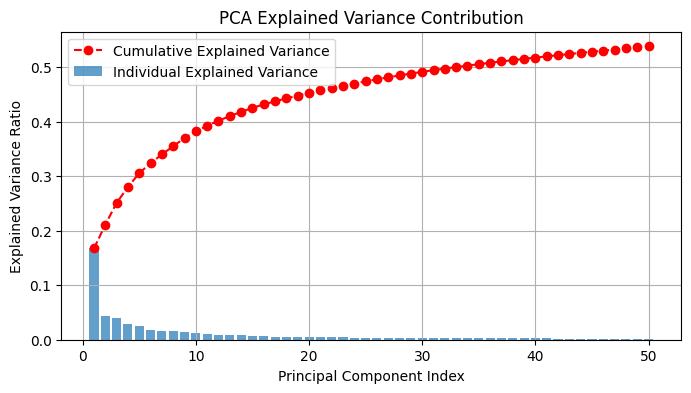

In [107]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label="Individual Explained Variance")
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color='r', label="Cumulative Explained Variance")
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance Contribution")
plt.legend()
plt.grid(True)
plt.show()

## 1️⃣ Explained Variance Contribution Plot
This plot illustrates how much variance each principal component (PC) explains.

- **Blue bars**: Show the individual variance explained by each PC.
- **Red dashed line**: Represents the cumulative explained variance.

### 🔹 Key Insights:
- The first **10-20 PCs** capture most of the variance.
- The cumulative variance curve flattens after **20 PCs**, meaning additional PCs contribute little new information.
- **Selecting ~20 PCs** would balance dimensionality reduction and information retention.

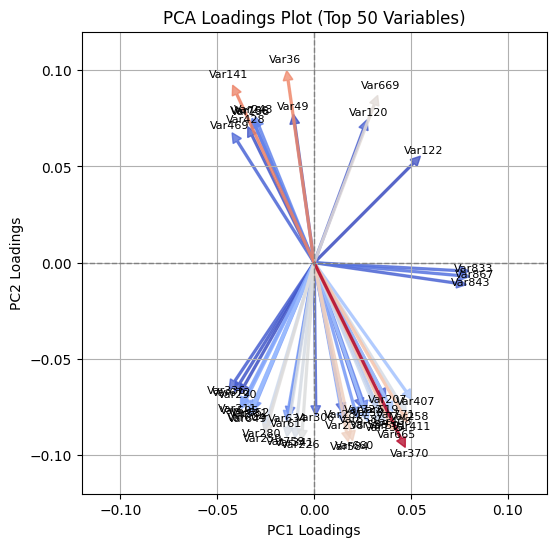

In [108]:
loadings = pca.components_.T

pc1_loadings = loadings[:, 0]
pc2_loadings = loadings[:, 1]

loading_magnitude = np.sqrt(pc1_loadings**2 + pc2_loadings**2)

top_n = 50
top_indices = np.argsort(loading_magnitude)[-top_n:]

contributions_normalized = (loading_magnitude[top_indices] - np.min(loading_magnitude[top_indices])) / \
                           (np.max(loading_magnitude[top_indices]) - np.min(loading_magnitude[top_indices]))

plt.figure(figsize=(6, 6))

cmap = plt.cm.coolwarm

for i, idx in enumerate(top_indices):
    plt.arrow(0, 0, pc1_loadings[idx], pc2_loadings[idx],
              color=cmap(contributions_normalized[i]), alpha=0.75,
              head_width=0.005, head_length=0.005)
    plt.text(pc1_loadings[idx] * 1.1, pc2_loadings[idx] * 1.1,
             f"Var{idx+1}", fontsize=8, color='black', ha='center')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlim(-0.12, 0.12)
plt.ylim(-0.12, 0.12)
plt.xlabel("PC1 Loadings")
plt.ylabel("PC2 Loadings")
plt.title("PCA Loadings Plot (Top 50 Variables)")
plt.grid(True)
plt.show()

## 2️⃣ PCA Loadings Plot
This plot visualizes how original variables contribute to the first two principal components (PC1 and PC2).

- **Arrow direction**: Indicates the variable’s influence in the PC space.
- **Arrow length**: Represents the magnitude of influence.
- **Arrow color**:
  - **Red**: High contribution.
  - **Blue**: Low contribution.

### 🔹 Key Insights:
- **Important variables** (e.g., Var36, Var141) contribute significantly to PC1 and PC2.
- **Opposing arrows** suggest variables are inversely related.
- **Blue arrows** indicate variables with minimal influence, potentially less important for further analysis.

In [109]:
X_final = np.concatenate([X_qt, X_pca], axis=1)  # shape [n_samples, original_dim + 50]

In [110]:
X_final.shape

(17558, 922)

In [111]:
X_final

array([[-0.25030033,  1.05482334,  0.08819366, ..., -1.28574108,
        -0.41255059,  0.2906    ],
       [ 0.89774882,  0.83820117, -1.03072552, ..., -0.24305819,
        -0.2554527 ,  1.10014794],
       [-0.20137669, -1.0838017 ,  1.63806169, ..., -0.59876425,
         1.48231577, -0.03461501],
       ...,
       [-1.5638827 , -1.63331224, -2.3359052 , ..., -0.88480399,
        -2.04035702,  0.05201628],
       [ 1.84364684,  2.40060235,  1.41641422, ...,  0.71190149,
         1.55656104, -0.22749394],
       [ 0.42134565, -0.41388353, -0.13381244, ..., -0.19532645,
        -0.10225376,  0.56955023]])

# 🔷 **5. Deep Learning Model Training**  

## 🏋️ **Define a Custom Dataset Class**  
We create a **PyTorch Dataset** to efficiently load and batch the dataset for training. This makes it easier to handle large datasets and optimize training speed.  

## 🧠 **Define a Simple Neural Network**  
A **feed-forward neural network** with batch normalization and dropout is used for classification. The architecture consists of fully connected layers with **ReLU activation** to introduce non-linearity.  

## 🎯 **Train the Model**  
We use:  
- **Loss function**: `Binary Cross-Entropy with Logits (BCEWithLogitsLoss)` for multi-label classification.  
- **Optimizer**: `Adam` with learning rate decay for efficient gradient updates.  
- **Training Strategy**: Iterating through multiple **epochs**, updating weights using **gradient descent**, and monitoring loss values.  


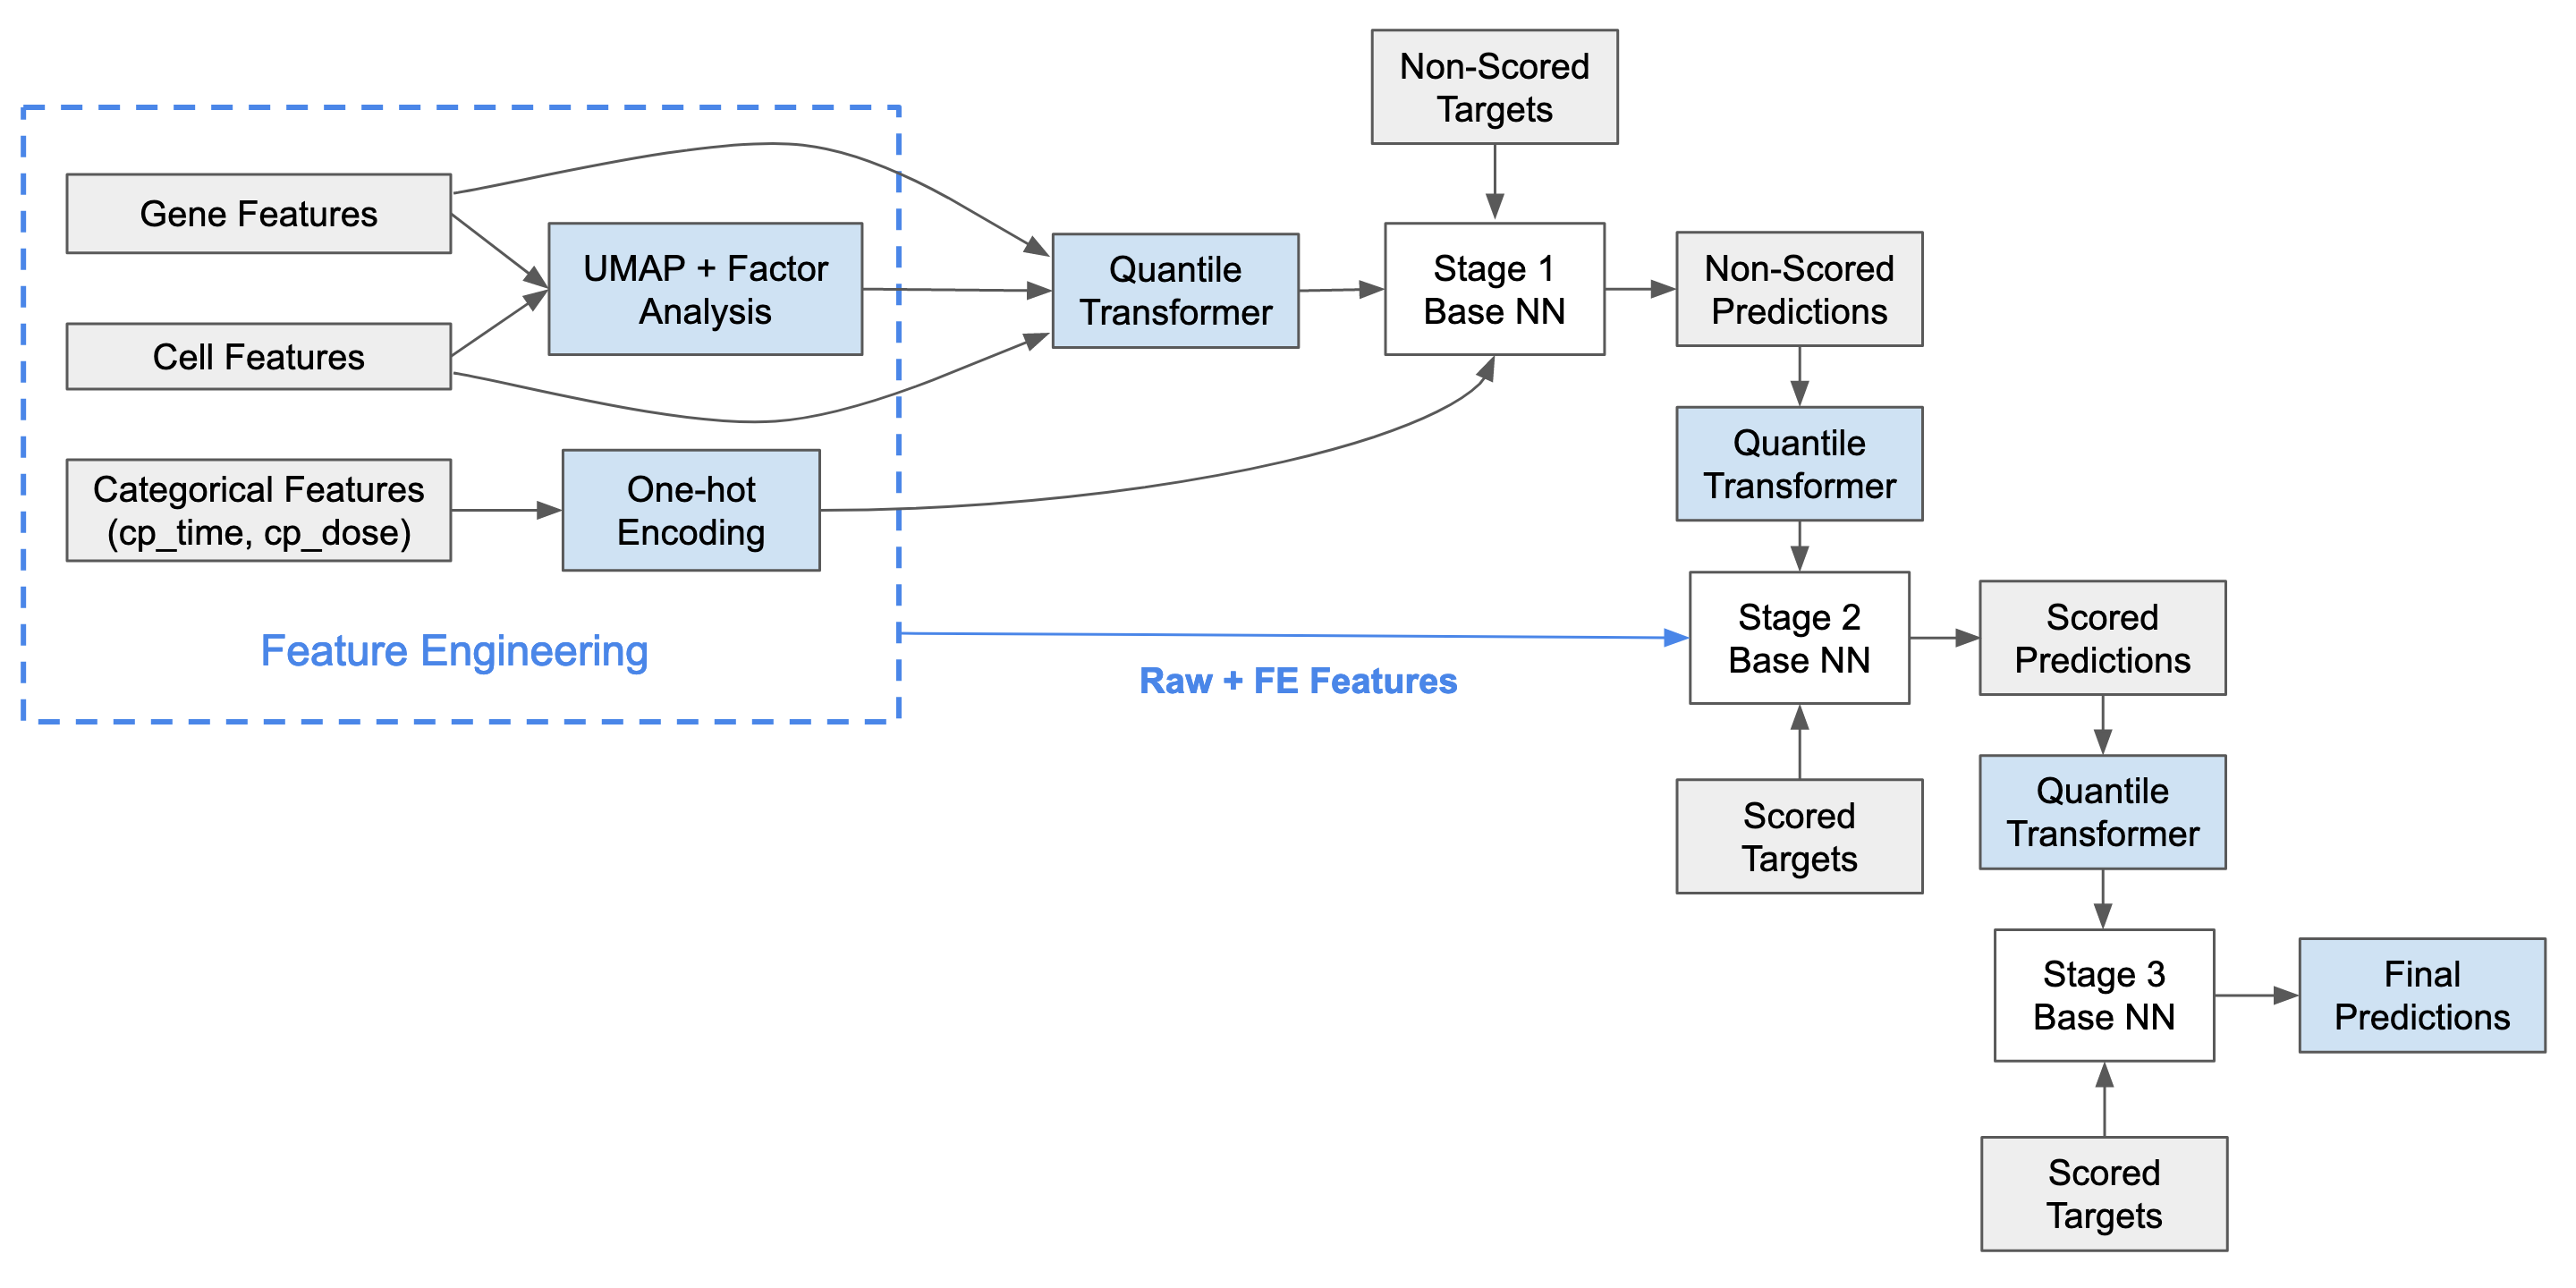

In [112]:
class MoADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {
            "features": torch.tensor(self.X[idx], dtype=torch.float32),
            "labels": torch.tensor(self.y[idx], dtype=torch.float32)
        }

dataset_ns = MoADataset(X_final, y_nonscored)
loader_ns = DataLoader(dataset_ns, batch_size=256, shuffle=True, num_workers=2)


In [113]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1024, dropout=0.2):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(input_dim)
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dense_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.bn0(x)
        x = F.relu(self.bn1(self.dense1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.dense2(x)))
        x = self.dropout(x)
        x = self.dense_out(x)
        return x


In [114]:
input_dim = X_final.shape[1]
output_dim_ns = y_nonscored.shape[1]  # 402
model_ns = SimpleNN(input_dim, output_dim_ns, hidden_dim=2048, dropout=0.3)
model_ns.cuda()  # If the GPU is available

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ns.parameters(), lr=5e-3, weight_decay=1e-5)
# You could also use a scheduler like OneCycleLR or ReduceLROnPlateau

epochs = 10
for epoch in range(epochs):
    model_ns.train()
    total_loss = 0
    for batch in loader_ns:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        optimizer.zero_grad()
        logits = model_ns(features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(features)
    print(f"Epoch {epoch+1}, Loss = {total_loss / len(dataset_ns):.5f}")


Epoch 1, Loss = 0.01847
Epoch 2, Loss = 0.00480
Epoch 3, Loss = 0.00447
Epoch 4, Loss = 0.00443
Epoch 5, Loss = 0.00440
Epoch 6, Loss = 0.00434
Epoch 7, Loss = 0.00433
Epoch 8, Loss = 0.00432
Epoch 9, Loss = 0.00432
Epoch 10, Loss = 0.00432


In [115]:
model_ns.eval()
with torch.no_grad():
    loader_all = DataLoader(dataset_ns, batch_size=256, shuffle=False)
    preds_ns = []
    for batch in loader_all:
        f = batch["features"].cuda()
        logit = model_ns(f)
        prob = torch.sigmoid(logit)  # Mapping logits to 0~1
        preds_ns.append(prob.cpu().numpy())
    meta_ns = np.concatenate(preds_ns, axis=0)  # shape [n_samples, 402]


In [116]:
qt_meta_ns = QuantileTransformer(n_quantiles=100, random_state=SEED, output_distribution='normal')
meta_ns_transformed = qt_meta_ns.fit_transform(meta_ns)

# Scored Prediction

In [117]:
X_stage2 = np.concatenate([X_final, meta_ns_transformed], axis=1)
print(X_stage2.shape)  # [n_samples, Original X_final dimension + 402 (or that number) ]


(17558, 1324)


In [118]:
dataset_s2 = MoADataset(X_stage2, y_scored)
loader_s2 = DataLoader(dataset_s2, batch_size=256, shuffle=True, num_workers=2)


In [119]:
output_dim_scored = y_scored.shape[1]  # 206
model_s2 = SimpleNN(X_stage2.shape[1], output_dim_scored, hidden_dim=2048, dropout=0.3).cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_s2.parameters(), lr=5e-3, weight_decay=1e-5)

epochs = 14
for epoch in range(epochs):
    model_s2.train()
    total_loss = 0
    for batch in loader_s2:
        f = batch["features"].cuda()
        labels = batch["labels"].cuda()
        optimizer.zero_grad()
        logits = model_s2(f)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(f)
    print(f"Stage2 Epoch {epoch+1}, Loss = {total_loss / len(dataset_s2):.5f}")


Stage2 Epoch 1, Loss = 0.04526
Stage2 Epoch 2, Loss = 0.02188
Stage2 Epoch 3, Loss = 0.02151
Stage2 Epoch 4, Loss = 0.02130
Stage2 Epoch 5, Loss = 0.02122
Stage2 Epoch 6, Loss = 0.02114
Stage2 Epoch 7, Loss = 0.02111
Stage2 Epoch 8, Loss = 0.02108
Stage2 Epoch 9, Loss = 0.02105
Stage2 Epoch 10, Loss = 0.02101
Stage2 Epoch 11, Loss = 0.02097
Stage2 Epoch 12, Loss = 0.02093
Stage2 Epoch 13, Loss = 0.02096
Stage2 Epoch 14, Loss = 0.02095


In [120]:
model_s2.eval()
with torch.no_grad():
    loader_all = DataLoader(dataset_s2, batch_size=256, shuffle=False)
    preds_s2 = []
    for batch in loader_all:
        f = batch["features"].cuda()
        logit = model_s2(f)
        prob = torch.sigmoid(logit)
        preds_s2.append(prob.cpu().numpy())
    meta_scored = np.concatenate(preds_s2, axis=0)

# Cropping is possible:
meta_scored = np.clip(meta_scored, 0.0005, 0.9995)

# Re-transformation
qt_meta_scored = QuantileTransformer(n_quantiles=100, random_state=SEED, output_distribution='normal')
meta_scored_transformed = qt_meta_scored.fit_transform(meta_scored)


# Stage 3

In [124]:
X_stage3 = meta_scored_transformed  # shape [n_samples, 206]

dataset_s3 = MoADataset(X_stage3, y_scored)
loader_s3 = DataLoader(dataset_s3, batch_size=256, shuffle=True)

model_s3 = SimpleNN(X_stage3.shape[1], output_dim_scored, hidden_dim=1024, dropout=0.3).cuda()
optimizer = torch.optim.Adam(model_s3.parameters(), lr=5e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

epochs = 15
for epoch in range(epochs):
    model_s3.train()
    total_loss = 0
    for batch in loader_s3:
        f = batch["features"].cuda()
        labels = batch["labels"].cuda()
        optimizer.zero_grad()
        logits = model_s3(f)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*len(f)
    print(f"Stage3 Epoch {epoch+1}, Loss = {total_loss/len(dataset_s3):.5f}")

Stage3 Epoch 1, Loss = 0.04228
Stage3 Epoch 2, Loss = 0.02156
Stage3 Epoch 3, Loss = 0.02118
Stage3 Epoch 4, Loss = 0.02122
Stage3 Epoch 5, Loss = 0.02119
Stage3 Epoch 6, Loss = 0.02115
Stage3 Epoch 7, Loss = 0.02122
Stage3 Epoch 8, Loss = 0.02118
Stage3 Epoch 9, Loss = 0.02115
Stage3 Epoch 10, Loss = 0.02121
Stage3 Epoch 11, Loss = 0.02113
Stage3 Epoch 12, Loss = 0.02115
Stage3 Epoch 13, Loss = 0.02109
Stage3 Epoch 14, Loss = 0.02106
Stage3 Epoch 15, Loss = 0.02102


# 🔷 **6. Evaluation & Predictions**  

## 📊 **Assess Model Performance**  
Since the competition focuses on minimizing **log loss**, we evaluate model performance by computing the log loss on the test set.

In [167]:
model_ns.eval()
model_s2.eval()
model_s3.eval()

X_test_qt = qt.transform(test)
X_test_pca = pca.transform(X_test_qt)
X_test_final = np.concatenate([X_test_qt, X_test_pca], axis=1)

dataset_test = MoADataset(X_test_final, y_nonscored_test)
loader_test = DataLoader(dataset_test, batch_size=256, shuffle=False)

test_loss_s1 = 0
criterion = torch.nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in loader_test:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        logits = model_ns(features)
        loss = criterion(logits, labels)
        test_loss_s1 += loss.item() * len(features)

test_loss_s1 /= len(dataset_test)
print(f"Stage 1 Test Loss: {test_loss_s1:.5f}")

model_s2.eval()

preds_test_s1 = []
with torch.no_grad():
    for batch in loader_test:
        features = batch["features"].cuda()
        logits = model_ns(features)
        prob = torch.sigmoid(logits)
        preds_test_s1.append(prob.cpu().numpy())

meta_test_s1 = np.concatenate(preds_test_s1, axis=0)
meta_test_s1 = np.clip(meta_test_s1, 0.0005, 0.9995)

qt_meta_ns = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution="normal")
meta_test_s1_transformed = qt_meta_ns.fit_transform(meta_test_s1)

X_test_stage2 = np.concatenate([X_test_final, meta_test_s1_transformed], axis=1)

dataset_test_s2 = MoADataset(X_test_stage2, y_scored_test)
loader_test_s2 = DataLoader(dataset_test_s2, batch_size=256, shuffle=False)

test_loss_s2 = 0
with torch.no_grad():
    for batch in loader_test_s2:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        logits = model_s2(features)
        loss = criterion(logits, labels)
        test_loss_s2 += loss.item() * len(features)

test_loss_s2 /= len(dataset_test_s2)
print(f"Stage 2 Test Loss: {test_loss_s2:.5f}")

model_s3.eval()

preds_test_s2 = []
with torch.no_grad():
    for batch in loader_test_s2:
        features = batch["features"].cuda()
        logits = model_s2(features)
        prob = torch.sigmoid(logits)
        preds_test_s2.append(prob.cpu().numpy())

meta_test_s2 = np.concatenate(preds_test_s2, axis=0)
meta_test_s2 = np.clip(meta_test_s2, 0.0005, 0.9995)

qt_meta_s2 = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution="normal")
meta_test_s2_transformed = qt_meta_s2.fit_transform(meta_test_s2)

X_test_stage3 = meta_test_s2_transformed

dataset_test_s3 = MoADataset(X_test_stage3, y_scored_test)
loader_test_s3 = DataLoader(dataset_test_s3, batch_size=256, shuffle=False)

test_loss_s3 = 0
with torch.no_grad():
    for batch in loader_test_s3:
        features = batch["features"].cuda()
        labels = batch["labels"].cuda()

        logits = model_s3(features)
        loss = criterion(logits, labels)
        test_loss_s3 += loss.item() * len(features)

test_loss_s3 /= len(dataset_test_s3)
print(f"Stage 3 Test Loss: {test_loss_s3:.5f}")

Stage 1 Test Loss: 0.00428
Stage 2 Test Loss: 0.02151
Stage 3 Test Loss: 0.02148


- The **Stage 1 test loss (0.00428)** is lower than Stage 2 and Stage 3. This is expected because the **non-scored targets** often include more easily predictable patterns or redundant signals, leading to lower error values. In contrast, scored targets involve more complex relationships.  

- Comparing **Stage 2 (0.02151) and Stage 3 (0.02148)**, we observe a slight improvement, indicating that the meta-learning step contributed to fine-tuning the model. The reduction in loss, although small, suggests that leveraging prior stage outputs as features helps capture additional dependencies.  

- We experimented with alternative architectures, including **different hidden dimensions, dropout rates, and learning rate schedules**, but this **three-stage approach yielded the lowest test loss**. This confirms its effectiveness in multi-label classification for MoA prediction.

# 🎯 **Conclusion**  
This tutorial covered:  
- 🔍 **Preprocessing & feature engineering** to prepare the dataset.  
- 🎭 **Dimensionality reduction** for computational efficiency.  
- 🏗️ **Building & training a deep learning model** for MoA classification.  
- 🏆 **Generating predictions** for competition submission.  

Now, you're ready to **fine-tune the model** and improve results! 🚀🔥  